In [1]:
%load_ext autoreload
%autoreload 2

from numcosmo_py import Ncm, Nc, GObject

from richness_mass_calib import create_richness_mass_calib
import numpy as np
import math
import sys
import os.path

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt

# Bibliotecas complementares
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats


#Settings
Ncm.cfg_init()

%matplotlib inline
sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy")

import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")

In [2]:
# DC2 data

DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits"
)
dt_halos = Table(DC2_halos_m200c[1].data)

# dt_halos['redshift_true', 'mass_fof', 'm200c', 'richness']

In [3]:
#catalog_cut = np.log(dt_halos['m200c']) < 31.0
#dt_halos = dt_halos[catalog_cut]

In [4]:
rmdata = create_richness_mass_calib(dt_halos)

use_ascaso = False

ascaso = Nc.ClusterMassAscaso()
ascaso.param_set_by_name("mup0", 4.45393539397061)
ascaso.param_set_by_name("mup1", 0.538092645909241)
ascaso.param_set_by_name("mup2", 0.931306629373459)
ascaso.param_set_by_name("sigmap0", 0.674689968522022)
ascaso.param_set_by_name("sigmap1", 0.0645030252979038)
ascaso.param_set_by_name("sigmap2", -0.244363116863723)
mset_ascaso = Ncm.MSet()
mset_ascaso.set(ascaso)

lnrich_ext = Nc.ClusterMassLnrichExt()
lnrich_ext.param_set_by_name("mu", 4.60456407051582)
lnrich_ext.param_set_by_name("muM1", 0.872079943089853)
lnrich_ext.param_set_by_name("muZ1", 1.77432682440775)
lnrich_ext.param_set_by_name("muM2", 0.0417736274804596)
lnrich_ext.param_set_by_name("muZ2", -0.140721577418961)
lnrich_ext.param_set_by_name("muMZ", 0.142254333837774)

lnrich_ext.param_set_by_name("sigma0", 0.288099083637692)
lnrich_ext.param_set_by_name("sigmaM1", 0.01665425603827)
lnrich_ext.param_set_by_name("sigmaZ1", -0.0170544925340452)
lnrich_ext.param_set_by_name("sigmaM2", 0.0151710348889877)
lnrich_ext.param_set_by_name("sigmaZ2", 0.00841242091702829)
lnrich_ext.param_set_by_name("sigmaMZ", 0.0375086602261856)

mset_ext = Ncm.MSet()
mset_ext.set(lnrich_ext)

In [5]:
dset = Ncm.Dataset.new()
dset.append_data(rmdata)

lh = Ncm.Likelihood.new(dset)

mset_ascaso.param_set_all_ftype(Ncm.ParamType.FREE)
mset_ext.param_set_all_ftype(Ncm.ParamType.FREE)

fit_ascaso = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ascaso, Ncm.FitGradType.NUMDIFF_CENTRAL
)
fit_ext = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ext, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit_ascaso.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
fit_ext.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.........................................................................................................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:19.4890310
#  iteration            [000964]
#  function evaluations [000966]
#  gradient evaluations [000000]
#  degrees of freedom   [454469]
#  m2lnL     =       329242.8984902 (      329242.9 )
#  Fit parameters:
#     4.45403697447098     0.688658961117589    1.23736811078756     0.227138540697068   -0.0514211618793634  -0.125451078175015   
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 501950.11407705       
#  - relative improvement: 0.603891161845443 

In [6]:
lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

In [7]:
# lnR mean and std

def compute_res(rich_model):

    lnR_mean = np.array(
        [rich_model.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    lnR_std = np.array(
        [rich_model.get_std_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )

    abs_err = (lnR - lnR_mean) / lnR_std
    # Data cut
    sigma_cut = 5.0

    sigma_cut_array = np.abs(abs_err) < sigma_cut
    print(f"Cutting {sigma_cut}-sigma, {np.sum(np.logical_not(sigma_cut_array))}")

    lnR_mean = lnR_mean[sigma_cut_array]
    z_sigma_cut = z[sigma_cut_array]
    lnM_sigma_cut = lnM[sigma_cut_array]
    abs_err = abs_err[sigma_cut_array]
    
    return abs_err, lnR_mean, z_sigma_cut, lnM_sigma_cut

res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso = compute_res(ascaso)
res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext = compute_res(lnrich_ext)



Cutting 5.0-sigma, 95
Cutting 5.0-sigma, 93


Text(0, 0.5, 'Residuals')

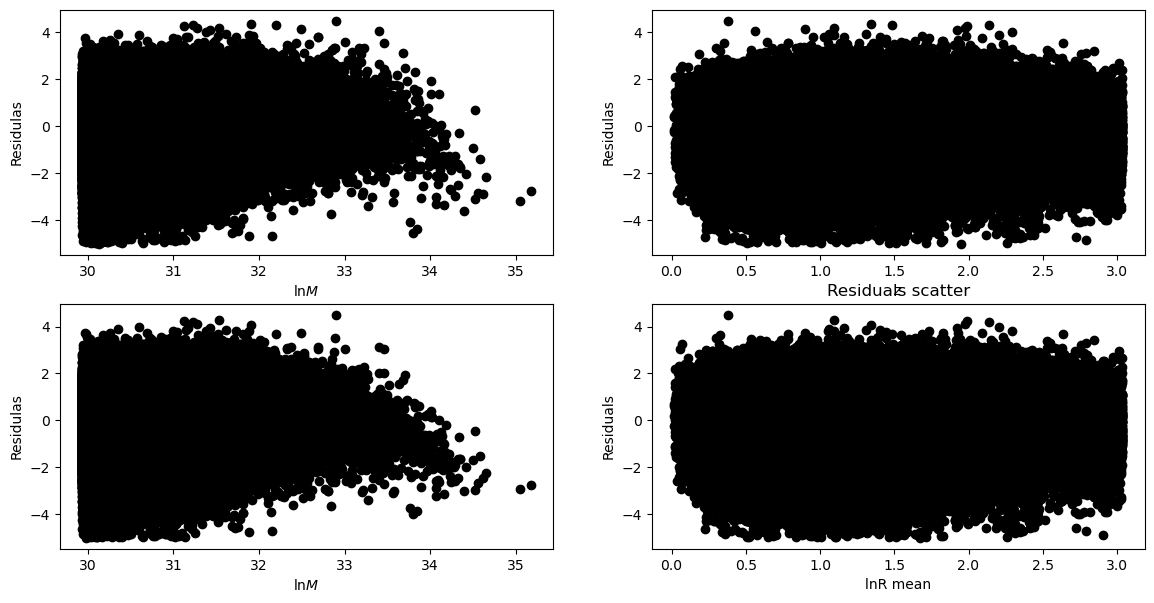

In [8]:
# Residuals

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.scatter(lnM_sigma_cut_ascaso, res_ascaso, c="k")
ax1.set_xlabel("$\ln M$")
ax1.set_ylabel("Residulas")

ax2.scatter(z_sigma_cut_ascaso, res_ascaso, c="k")
ax2.set_xlabel("$z$")
ax2.set_ylabel("Residulas")

ax3.scatter(lnM_sigma_cut_ext, res_ext, c="k")
ax3.set_xlabel("$\ln M$")
ax3.set_ylabel("Residulas")

ax4.scatter(z_sigma_cut_ext, res_ext, c="k")
ax4.set_xlabel("$z$")
ax4.set_ylabel("Residulas")


In [11]:
lnM_array = np.linspace(min(lnM), max(lnM), 100)
z_array = np.linspace(min(z), max(z), 100)

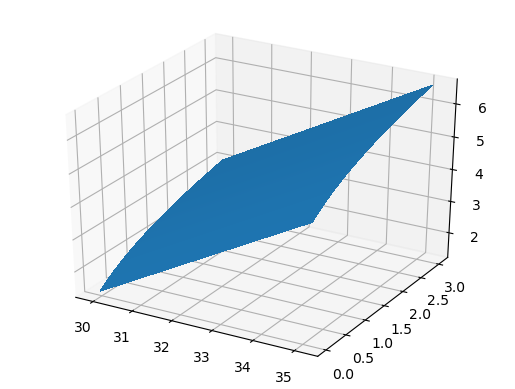

In [12]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X, Y = np.meshgrid(lnM_array, z_array)

Z = np.vectorize(ascaso.get_mean_richness)(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,
                       linewidth=0, antialiased=False)

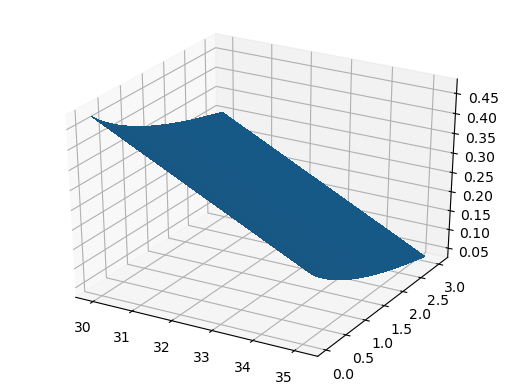

In [13]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X, Y = np.meshgrid(lnM_array, z_array)

Z = np.vectorize(ascaso.get_std_richness)(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,
                       linewidth=0, antialiased=False)

In [14]:
fit_ascaso.numdiff_m2lnL_covar()
fit_ext.numdiff_m2lnL_covar()

In [28]:
cov_ascaso = np.square(fit_ascaso.get_covar().dup_array())
cov_ext = np.square(fit_ext.get_covar().dup_array())

dascaso = int(np.sqrt(len(cov_ascaso)))
cov_ascaso = cov_ascaso.reshape(dascaso, dascaso)

dext = int(np.sqrt(len(cov_ext)))
cov_ext = cov_ext.reshape(dext, dext)

In [40]:
from numpy import linalg as lg

Eigenvalues, Eigenvectors = lg.eig(cov_ext)

print(Eigenvalues)
Eigenvectors[0]
Eigenvectors[1]
Eigenvectors[10]

[1.72133798e-08 4.20321248e-09 3.52363568e-09 1.73072867e-09
 6.26172702e-10 4.45715048e-10 1.57991356e-10 5.77506816e-11
 2.96554230e-11 1.32569010e-11 3.21149125e-14 6.75213112e-15]


array([-5.63379126e-05,  2.84749056e-04, -6.33072064e-03,  5.45037720e-05,
        5.73796623e-03, -9.99767830e-01, -5.79627672e-04, -1.18788328e-04,
        1.64563349e-03, -1.97008864e-02, -7.29007444e-06,  1.15333962e-04])

Text(0.5, 1.0, 'Residuals distribuition')

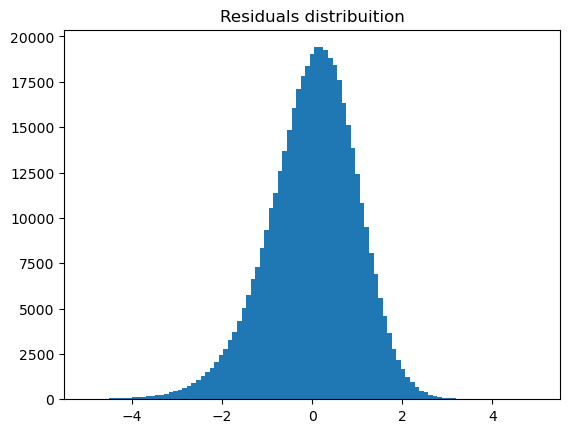

In [9]:
plt.hist(abs_err, bins=np.linspace(-5, 5, 100))
plt.title("Residuals distribuition")

In [10]:
print(stats.shapiro(abs_err))
print(stats.kstest(abs_err, "norm"))

ShapiroResult(statistic=0.988969087600708, pvalue=0.0)
KstestResult(statistic=0.030269089891114875, pvalue=0.0, statistic_location=-0.090470287305661, statistic_sign=-1)


/global/homes/v/vitenti/.conda/envs/numcosmo/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [11]:
print(f"mean {np.mean(abs_err)} std {np.std(abs_err)}")

mean 0.0011500214032946383 std 0.9969803029028247


In [12]:
# fig = plt.figure()
# ax = fig.add_subplot()
# stats.probplot(abs_err, dist="norm", plot=ax)
# plt.show()

Text(0.5, 1.0, 'Redshift distribuition')

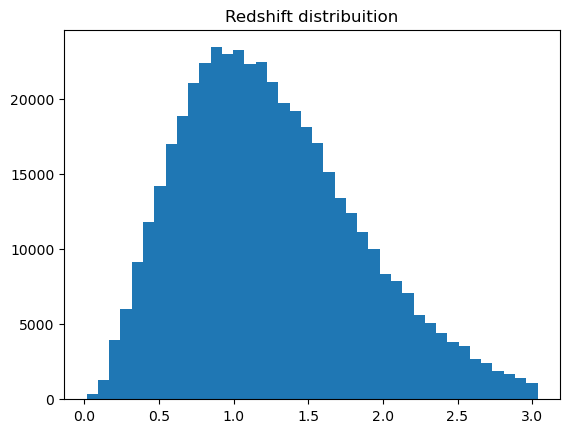

In [13]:
plt.hist(z, bins=40)
plt.title("Redshift distribuition")

In [14]:
z_sigma_cut_cut = np.logical_and(z_sigma_cut > 0.1, z_sigma_cut < 0.4)

Text(0.5, 1.0, 'Residuals distribuition')

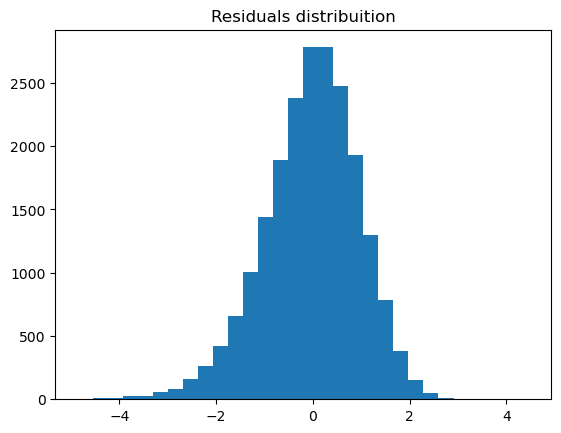

In [15]:
plt.hist(abs_err[z_sigma_cut_cut], bins=30)
plt.title("Residuals distribuition")

Text(0.5, 1.0, 'Mass distribuition')

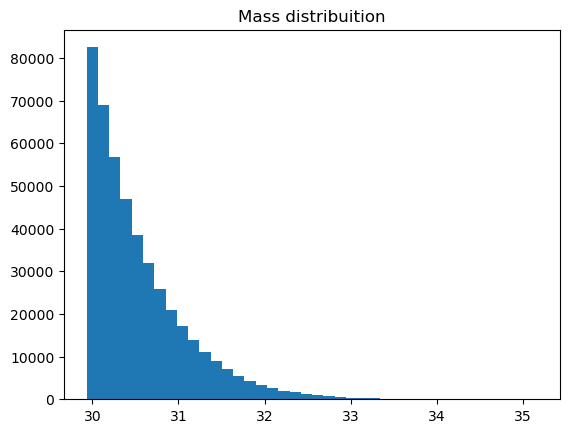

In [16]:
plt.hist(lnM_sigma_cut, bins=40)
plt.title("Mass distribuition")

In [17]:
print(f"{np.exp(min(lnM_sigma_cut)):e}")

1.000236e+13


In [18]:
lnM_sigma_cut_cut = np.logical_and(lnM_sigma_cut > 31.0, lnM_sigma_cut < 31.2)

Text(0.5, 1.0, 'Residuals distribuition')

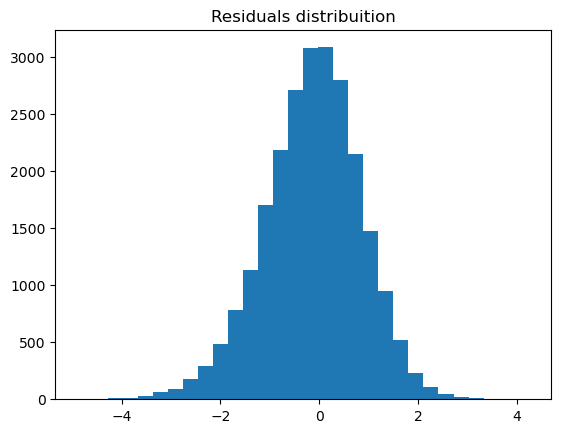

In [19]:
plt.hist(abs_err[lnM_sigma_cut_cut], bins=30)
plt.title("Residuals distribuition")

In [20]:
print(f"{stats.skew(abs_err)} {stats.kurtosis(abs_err)}")

-0.4531266400265952 0.6509070766724592


In [22]:
# MCMC
# Parameters posterior distribuition

# mcmc_fits = Table(fits.open('NumCosmo/MCMC_ascaso_test.fits')[1].data) #MCMC first results

dt_mcmc = list(Table(fits.open("MCMC_ascaso_test2.fits")[1].data))

df = pd.DataFrame(dt_mcmc)
df.columns = ["m2lnL", "mup0", "mup1", "mup2", "sigmap0", "sigmap1", "sigmap2"]

df_param = df[["mup0", "mup1", "mup2", "sigmap0", "sigmap1", "sigmap2"]]

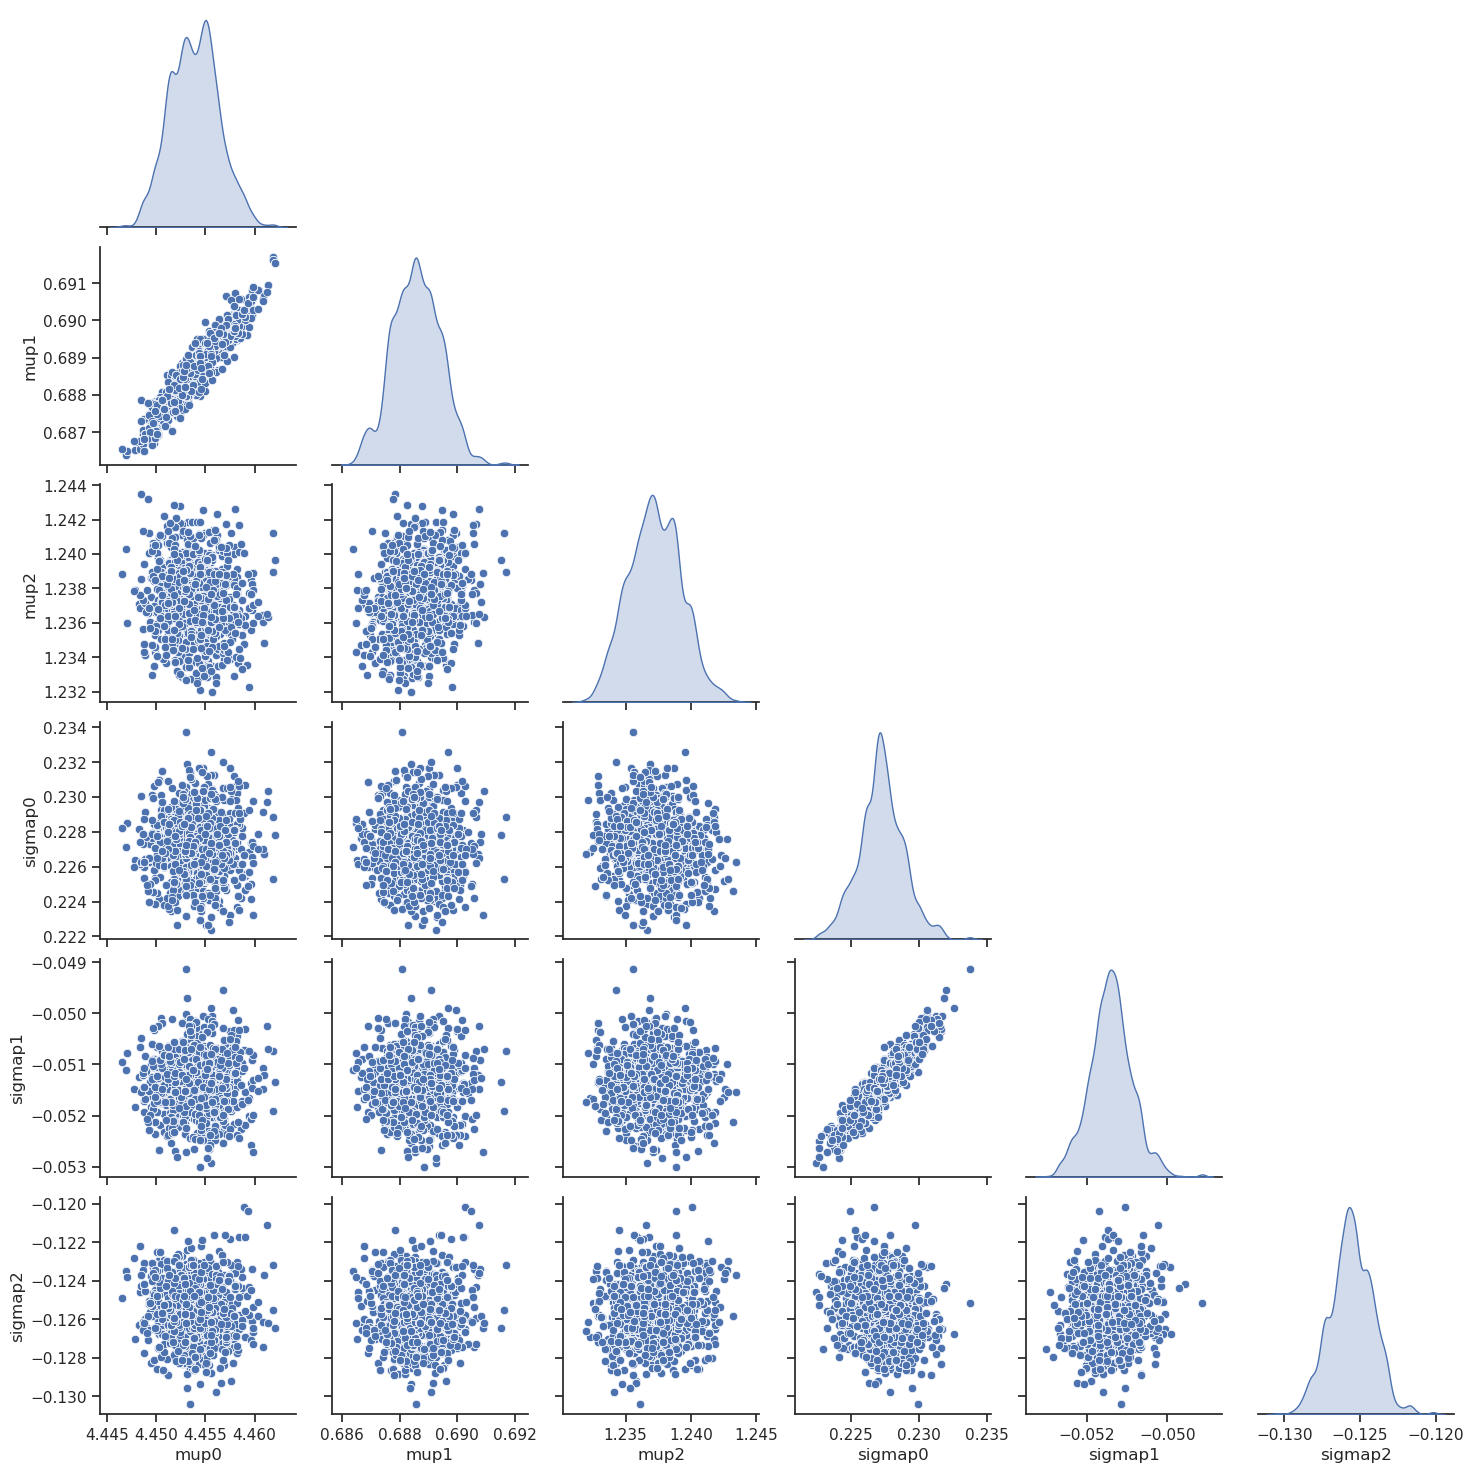

In [23]:
sns.set_theme(style="ticks", color_codes="r")
sns.pairplot(data=df_param, corner=True, diag_kind="kde")

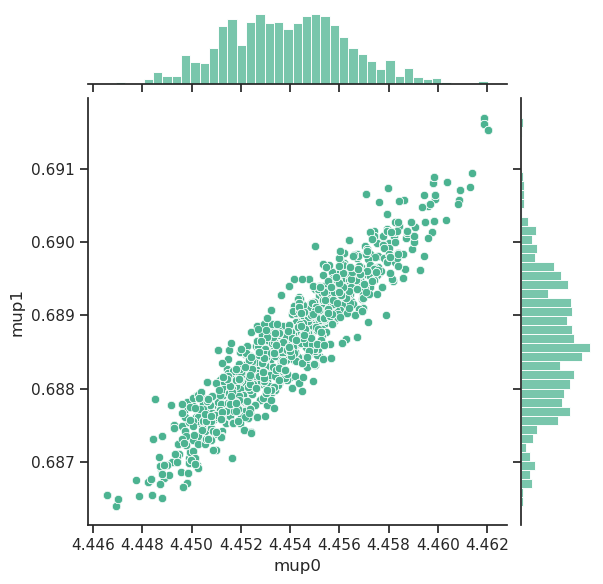

In [24]:
sns.jointplot(x=df_param["mup0"], y=df_param["mup1"], color="#4CB391")

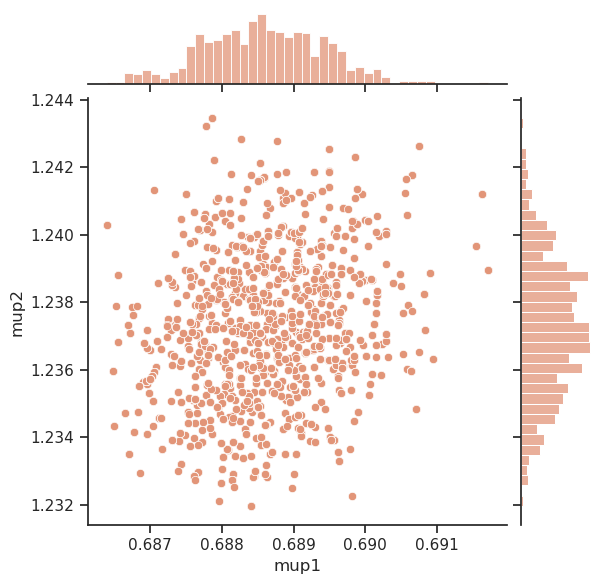

In [25]:
sns.jointplot(x=df_param["mup1"], y=df_param["mup2"], color="#E29578")

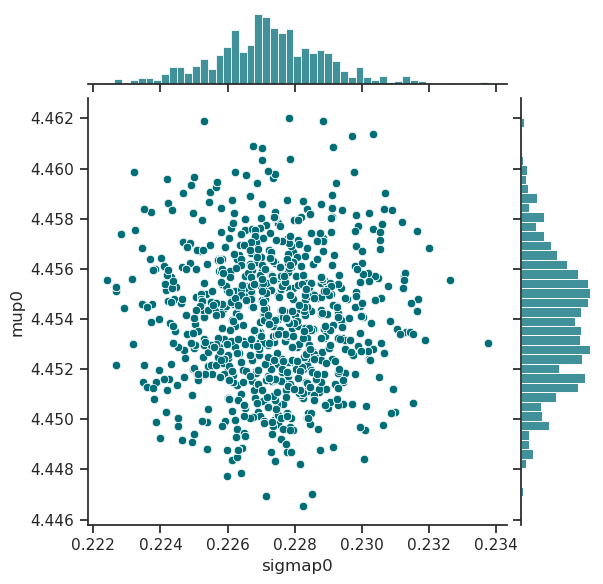

In [26]:
sns.jointplot(x=df_param["sigmap0"], y=df_param["mup0"], color="#006D77")